In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter, defaultdict
from functools import partial
import math, random
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# dataset
data = [
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
        ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
        ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
        ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
        ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
        ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
    ]

# 의사결정나무
- 엔트로피 계산
- 파티션의 엔트로피 계산
- 재귀적 분할

## 1. 엔트로피 계산

In [4]:
def class_probabilities(labels):
    """라벨 수를 계산하고 각 클래스의 확률 계산"""
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

In [5]:
def entropy(class_probabilities):
    """클래스에 속할 확률을 입력하면 엔트로피 계산
    if p : 확률이 0인 경우는 제외함 """
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

In [7]:
def data_entropy(labeled_data):
    """클래스 비율을 토대로 데이터 전체 엔트로피 계산"""
    labels = [label for _, label in labeled_data] # 데이터를 받아서 레이블 정보만 뺀 뒤 리스트로 저장
    probabilities = class_probabilities(labels)   # 클래스 비율 계산
    return entropy(probabilities)                 # 클래스 비율을 토대로 엔트로피 계산

## 2. 파티션의 엔트로피 계산
- 의사결정나무의 각 단계는 데이터를 여러 개의 파티션으로 분할하기 때문에 데이터가 여러 개의 작은 셋으로 나뉘게 된다.
- 하나의 데이터 셋을 여러 개의 파티션으로 나뉘더라도 데이터셋 전체에 대한 엔트로피를 계산해야된다.
    - 파티션 하나하나가 낮은 엔트로피를 갖는 경우 전반적으로 엔트로피도 낮아야한다.
- 데이터 S를 $q_1, q_2, q_3..$의 비율을 가지는 파티션 $s_1, s_2, s_3 ...$으로 나누는 경우, 전체 엔트로피는 각 파티션 엔트로피의 가중합으로 구한다.
    - $H=q_1H(s_1)+...+q_mH(s_m)$

In [8]:
def partition_entropy(subsets):
    """subset은 레이블이 있는 데이터의 list의 list
        그에 대한 엔트로피를 계산한 뒤 모든 subset의 엔트로피 합친 값 반환"""
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)   # subset A의 엔트로피는 A 요소별 엔트로피의 합 * A의 영역 비율

In [9]:
def partition_by(inputs, attribute):
    """attribute 기준으로 inputs를 부분 집합으로 분리"""
    # attribute 변수 내에 3개 값이 있다면 그룹수 = 3
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute]  # 특정 attribute의 값을 불러옴
        groups[key].append(input) # 이 input을 올바른 list에 추가
    return groups

In [10]:
def partition_entropy_by(inputs, attribute):
    """주어진 파티션에 대응되는 엔트로피를 계산"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

## 3. 재귀적 분할을 이용한 의사결정나무
### (1) 재귀용법
- 하나의 함수에서 자신을 다시 호출하여 작업을 수행하는 방식으로 주어진 문제를 푸는 방법.


- #### 예시

```
어느 한 컴퓨터공학과 학생이 유명한 교수님을 찾아가 물었다.

"재귀함수가 뭔가요?"
"잘 들어보게. 옛날옛날 한 산 꼭대기에 이세상 모든 지식을 통달한 선인이 있었어. 마을 사람들은 모두 그 선인에게 수많은 질문을 했고, 모두 지혜롭게 대답해 주었지. 그의 답은 대부분 옳았다고 하네.
그런데 어느날, 그 선인에게 한 선비가 찾아와서 물었어.
    "재귀함수가 뭔가요?"
     "잘 들어보게. 옛날옛날 한 산 꼭대기에 이세상 모든 지식을 통달한 선인이 있었어. 마을 사람들은 모두 그 선인에게 수많은 질문을 했고, 모두 지혜롭게 대답해 주었지. 
     그의 답은 대부분 옳았다고 하네.
     그런데 어느날, 그 선인에게 한 선비가 찾아와서 물었어.
            "재귀함수가 뭔가요?"
            "잘 들어보게. 옛날옛날 한 산 꼭대기에...

```

In [11]:
def countdown(n):
    if n == 0:
        print("KO!")
    else:
        print(n)
        countdown(n-1)

In [12]:
countdown(10)

10
9
8
7
6
5
4
3
2
1
KO!


In [13]:
def factorial(num):
    # n!
    if num == 0:
        return 1
    else:
        return num * factorial(num - 1)

In [14]:
factorial(3)

6

### (2) ID3 알고리즘
- 모든 데이터 포인트의 클래스 레이블이 동일하다면, 그 예측값이 해당 클래스 레이블인 자식 노드를 만들고 종료하라.
- 파티션을 나눌 수 있는 변수가 남아 있지 않다면, 가장 빈도 수가 높은 클래스 레이블로 예측하는 자식 노드를 만들고 종료하라.
- 그게 아니면, 각 변수로 데이터의 파티션을 나눠라.
- 파티션을 나눴을 때 엔트로피가 가장 낮은 변수를 택하라.
- 선택된 변수에 대한 결정 노드를 추가하라.
- 남아 있는 변수들로 각 파티션에 대한 위 과정을 반복하라.

> - 매 순간에만 최적의 선택을 한다. (greedy 알고리즘)
- 범주형 속성에만 사용 가능하다.
- 상위 노드에서 사용된 속성은 사용하지 않는다.
- 이해하기 쉽고, 구현하기도 쉽다.

In [15]:
data

[({'lang': 'Java', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}, False),
 ({'lang': 'Java', 'level': 'Senior', 'phd': 'yes', 'tweets': 'no'}, False),
 ({'lang': 'Python', 'level': 'Mid', 'phd': 'no', 'tweets': 'no'}, True),
 ({'lang': 'Python', 'level': 'Junior', 'phd': 'no', 'tweets': 'no'}, True),
 ({'lang': 'R', 'level': 'Junior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'R', 'level': 'Junior', 'phd': 'yes', 'tweets': 'yes'}, False),
 ({'lang': 'R', 'level': 'Mid', 'phd': 'yes', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}, False),
 ({'lang': 'R', 'level': 'Senior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Junior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Senior', 'phd': 'yes', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Mid', 'phd': 'yes', 'tweets': 'no'}, True),
 ({'lang': 'Java', 'level': 'Mid', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 

In [16]:
def build_tree(inputs, split_candidates=None):
    """ID3 알고리즘"""
    from functools import partial
    # 첫 분할라면 입력 데이터의 모든 변수가 분할 후보
    if split_candidates is None:
        # 'lang', 'tweets', 'phd', 'level' 모두 후보
        split_candidates = inputs[0][0].keys()

    num_inputs = len(inputs)                                  # 입력 데이터에서 범주별 개수를 세어 본다
    num_class0 = len([label for _, label in inputs if label]) # label이 True인 경우만 센다.
    num_class1 = num_inputs - num_class0                      # label이 False인 경우만 센다.

    # class0(true)이 하나도 없으면 False leaf 반환
    if num_class0 == 0: return False
    
    # class1(false)이 하나도 없으면 Ture leaf 반환
    if num_class1 == 0: return True

    # 파티션 기준으로 사용할 변수가 없다면
    if not split_candidates:
        # 다수결로 결정
        # class0(true)가 같거나 많으면 true,
        # class1(false)가 많으면 false 반환
        return num_class0 >= num_class1

    # 아니면 가장 적합한 변수를 기준으로 분할
    best_attribute = min(split_candidates, key=partial(partition_entropy_by, inputs))
    # partial(partition_entropy_by, inputs) -> partition_entropy_by(inputs, 변수), inputs를 고정시키고 attributes만 변수로 받는 새로운 함수로 변형
    
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    # 재귀적으로 서브트리를 구축
    subtrees = { attribute_value : build_tree(subset, new_candidates)
                 for attribute_value, subset in partitions.items()}
    # 기본값
    subtrees[None] = num_class0 > num_class1
    return (best_attribute, subtrees)

In [17]:
build_tree(data)

('level',
 {'Junior': ('phd', {None: True, 'no': True, 'yes': False}),
  'Mid': True,
  None: True,
  'Senior': ('tweets', {None: False, 'no': False, 'yes': True})})

<img src="https://minzzzy.github.io/images/dt_1.png" alt="Drawing" style="width: 400px;" align = "left"/>

### 4. 분류

In [18]:
def classify(tree, input):
    """주어진 tree를 기준으로 input을 분류"""
    # 잎 노드이면 값 반환
    if tree in [True, False]:
        return tree

    # 그게 아니면 데이터의 변수로 분할
    # 키로 변수값, 값으로 서브트리를 나타내는 dict 사용
    attribute, subtree_dict = tree

    # 만약 입력된 데이터 변수 가운데 하나가
    # 기존에 관찰되지 않았다면 None
    ## input은 dict이므로 get 함수를 사용하면 key값이 존재하지 않을 때 에러가 나지 않도록 한다.
    subtree_key = input.get(attribute)

    # 키에 해당하는 서브트리가 존재하지 않을 때
    if subtree_key not in subtree_dict:
        # None 서브트리를 사용
        subtree_key = None

    # 적절한 서브트리를 선택
    subtree = subtree_dict[subtree_key]
    # 그리고 입력된 데이터를 분류
    return classify(subtree, input)

In [19]:
tree = build_tree(data)
print(classify(tree,
        { "level" : "Junior",
          "lang" : "Java",
          "tweets" : "yes",
          "phd" : "no"} ))

print(classify(tree,
        { "level" : "Junior",
          "lang" : "Java",
          "tweets" : "yes",
          "phd" : "yes"} ))


True
False


# #sklearn을 활용한 의사결정나무

- iris 데이터 활용
- decision tree 그림
    - conda install python-graphviz

In [20]:
from sklearn import datasets
iris = datasets.load_iris()
x = iris.data
y = iris.target

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2).fit(x, y)

In [23]:
def draw_decision_tree(model, features):
    import io
    import pydot
    from IPython.core.display import Image 
    from sklearn.tree import export_graphviz
    
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=features)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)


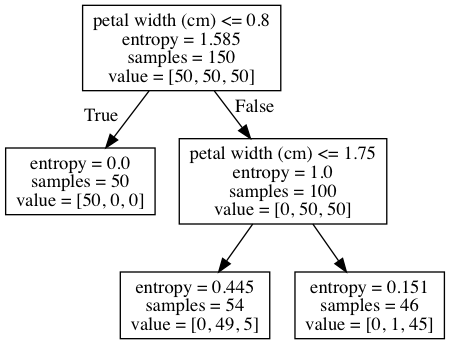

In [24]:
draw_decision_tree(dt, iris.feature_names)